# N-Year Storms
N-Year storms are defined by a getting x inches of rain in y minutes/hours/days.  For Chicago (Northeast Illinois), these thresholds are defined by Bulletin 70, and can be reviewed [here](http://www.isws.illinois.edu/atmos/statecli/RF/rf.htm).

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
from datetime import datetime, timedelta
import operator
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib notebook

In [30]:
# The following code is adopted from Pat's Rolling Rain N-Year Threshold.pynb
# Loading in hourly rain data from CSV, parsing the timestamp, and adding it as an index so it's more useful

rain_df = pd.read_csv('data/ohare_hourly_20160929.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
rain_df = rain_df['19700101':]
chi_rain_series = rain_df['HOURLYPrecip'].resample('1H', label='right').max().fillna(0)
chi_rain_series.head()

1970-01-01 04:00:00    0.0
1970-01-01 05:00:00    0.0
1970-01-01 06:00:00    0.0
1970-01-01 07:00:00    0.0
1970-01-01 08:00:00    0.0
Freq: H, Name: HOURLYPrecip, dtype: float64

In [31]:
# N-Year Storm variables
# These define the thresholds laid out by bulletin 70, and transfer mins and days to hours
n_year_threshes = pd.read_csv('../../n-year/notebooks/data/n_year_definitions.csv')
n_year_threshes = n_year_threshes.set_index('Duration')
dur_str_to_hours = {
    '5-min':5/60.0,
    '10-min':10/60.0,
    '15-min':15/60.0,
    '30-min':0.5,
    '1-hr':1.0,
    '2-hr':2.0,
    '3-hr':3.0,
    '6-hr':6.0,
    '12-hr':12.0,
    '18-hr':18.0,
    '24-hr':24.0,
    '48-hr':48.0,
    '72-hr':72.0,
    '5-day':5*24.0,
    '10-day':10*24.0
}
n_s = [int(x.replace('-year','')) for x in reversed(list(n_year_threshes.columns.values))]
duration_strs = sorted(dur_str_to_hours.items(), key=operator.itemgetter(1), reverse=False)
n_year_threshes

,1-year,2-year,5-year,10-year,25-year,50-year,100-year
Duration,,,,,,,
10-day,4.12,4.95,6.04,6.89,8.18,9.38,11.14
5-day,3.25,3.93,4.91,5.70,6.93,8.04,9.96
72-hr,2.93,3.55,4.44,5.18,6.32,7.41,8.78
48-hr,2.70,3.30,4.09,4.81,5.88,6.84,8.16
24-hr,2.51,3.04,3.80,4.47,5.51,6.46,7.58
18-hr,2.30,2.79,3.50,4.11,5.06,5.95,6.97
12-hr,2.18,2.64,3.31,3.89,4.79,5.62,6.59
6-hr,1.88,2.28,2.85,3.35,4.13,4.85,5.68
3-hr,1.60,1.94,2.43,2.86,3.53,4.14,4.85


In [32]:
# Roll through the rain series in intervals at the various durations, and look for periods that exceed the thresholds above.
# Return a DataFrame
def find_n_year_storms(start_time, end_time, n):
    n_index = n_s.index(n)
    next_n = n_s[n_index-1] if n_index != 0 else None
    storms = []

    for duration_tuple in reversed(duration_strs):

        duration_str = duration_tuple[0]
        low_thresh = n_year_threshes.loc[duration_str, str(n) + '-year']
        high_thresh = n_year_threshes.loc[duration_str, str(next_n) + '-year'] if next_n is not None else None
        
        duration = int(dur_str_to_hours[duration_str])
        sub_series = chi_rain_series[start_time: end_time]
        rolling = sub_series.rolling(window=int(duration), min_periods=0).sum()
        
        if high_thresh is not None:
            event_endtimes = rolling[(rolling >= low_thresh) & (rolling < high_thresh)].sort_values(ascending=False)
        else:
            event_endtimes = rolling[(rolling >= low_thresh)].sort_values(ascending=False)
        for index, event_endtime in event_endtimes.iteritems():
            storms.append({'n': n, 'end_time': index, 'inches': event_endtime, 'duration_hrs': duration,
                          'start_time': index - timedelta(hours=duration)})
    return pd.DataFrame(storms)

In [33]:
# Find all of the n-year storms in the whole rainfall dataset
n_year_storms_raw = find_n_year_storms(chi_rain_series.index[0], chi_rain_series.index[-1], 100)
for n in n_s[1:]:
    n_year_storms_raw = n_year_storms_raw.append(find_n_year_storms(chi_rain_series.index[0], chi_rain_series.index[-1], n))
n_year_storms_raw.head()

,duration_hrs,end_time,inches,n,start_time
0,240,1987-08-21 23:00:00,13.55,100,1987-08-11 23:00:00
1,240,1987-08-22 05:00:00,13.55,100,1987-08-12 05:00:00
2,240,1987-08-22 07:00:00,13.55,100,1987-08-12 07:00:00
3,240,1987-08-22 08:00:00,13.55,100,1987-08-12 08:00:00
4,240,1987-08-22 09:00:00,13.55,100,1987-08-12 09:00:00


In [36]:
# Re-order the dataframe to make it clearer
n_year_storms_raw = n_year_storms_raw[['n', 'duration_hrs', 'start_time', 'end_time', 'inches']]
n_year_storms_raw.head()

,n,duration_hrs,start_time,end_time,inches
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55
1,100,240,1987-08-12 05:00:00,1987-08-22 05:00:00,13.55
2,100,240,1987-08-12 07:00:00,1987-08-22 07:00:00,13.55
3,100,240,1987-08-12 08:00:00,1987-08-22 08:00:00,13.55
4,100,240,1987-08-12 09:00:00,1987-08-22 09:00:00,13.55


#### Just by looking over the first few rows of the dataframe, we can see that there is a lot of overlap.  We should assume that two n-year storms cannot overlap.  Create a new dataframe for unique events, in which we take the highest n over a given time period.

In [37]:
unique_storms = pd.DataFrame(n_year_storms_raw[0:1])
unique_storms.head()

,n,duration_hrs,start_time,end_time,inches
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55


In [38]:
# This method takes in a start time and end time, and searches unique_storms to see if a storm with these times
# overlaps with anything already in unique_storms.  Returns True if it overlaps with an existing storm
def overlaps(start_time, end_time):
    Range = namedtuple('Range', ['start', 'end'])
    range_to_check = Range(start=start_time, end=end_time)
    for index, row in unique_storms.iterrows():
        date_range = Range(start=row['start_time'], end=row['end_time'])
        latest_start = max(range_to_check.start, date_range.start)
        earliest_end = min(range_to_check.end, date_range.end)
        if  ((earliest_end - latest_start).days + 1) > 0:
            return True
    return False
s = pd.to_datetime('1987-08-11 01:00:00')
e = pd.to_datetime('1987-08-11 23:59:00')
overlaps(s,e)

True

In [39]:
# Iterate through n_year_storms_raw and if an overlapping storm does not exist in unique_storms, then add it
for index, storm in n_year_storms_raw.iterrows():
    if not overlaps(storm['start_time'], storm['end_time']):
        unique_storms = unique_storms.append(storm)
unique_storms.head()

,n,duration_hrs,start_time,end_time,inches
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55
169,100,240,2008-09-04 13:00:00,2008-09-14 13:00:00,11.94
378,100,24,2011-07-22 08:00:00,2011-07-23 08:00:00,7.86
693,50,24,2010-07-23 16:00:00,2010-07-24 16:00:00,6.54
759,50,3,2001-08-30 21:00:00,2001-08-31 00:00:00,4.27


In [40]:
# How many of each n-year storm did we see?
unique_storms['n'].value_counts().sort_index()

1      36
2      24
5      11
10      5
25      2
50      2
100     3
Name: n, dtype: int64

In [42]:
unique_storms.dtypes

n                        int64
duration_hrs             int64
start_time      datetime64[ns]
end_time        datetime64[ns]
inches                 float64
year                     int64
dtype: object

### Let's take a look at the number of n-year storms per year

In [43]:
def find_year(timestamp):
    return timestamp.year
unique_storms['year'] = unique_storms['start_time'].apply(find_year)
unique_storms.head()

,n,duration_hrs,start_time,end_time,inches,year
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55,1987
169,100,240,2008-09-04 13:00:00,2008-09-14 13:00:00,11.94,2008
378,100,24,2011-07-22 08:00:00,2011-07-23 08:00:00,7.86,2011
693,50,24,2010-07-23 16:00:00,2010-07-24 16:00:00,6.54,2010
759,50,3,2001-08-30 21:00:00,2001-08-31 00:00:00,4.27,2001


<IPython.core.display.Javascript object>


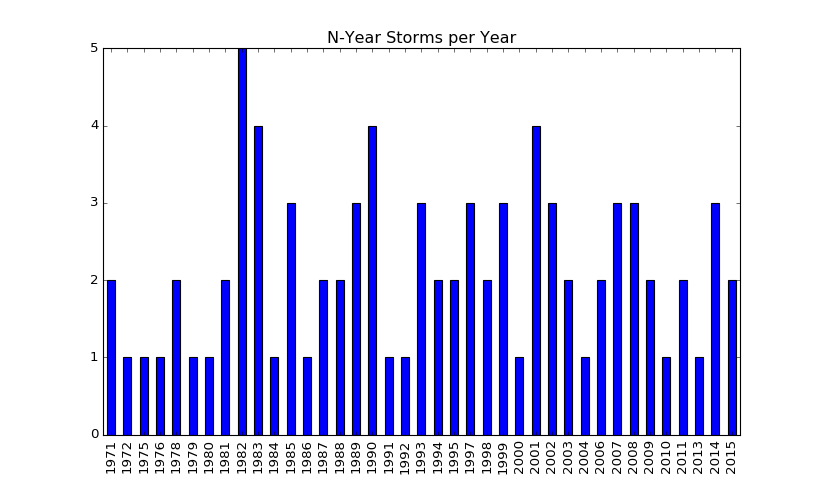

In [45]:
unique_storms['year'].value_counts().sort_index().plot(kind='bar', title='N-Year Storms per Year')

### Let's break up the different n's per year

In [61]:
ns_by_year = {year: {n: 0 for n in n_s} for year in range(1970, 2017)}
for index, event in unique_storms.iterrows():
    ns_by_year[event['year']][int(event['n'])] += 1
ns_by_year = pd.DataFrame(ns_by_year).transpose()
ns_by_year.head()

,1,2,5,10,25,50,100
1970,0,0,0,0,0,0,0
1971,1,1,0,0,0,0,0
1972,0,1,0,0,0,0,0
1973,0,0,0,0,0,0,0
1974,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>


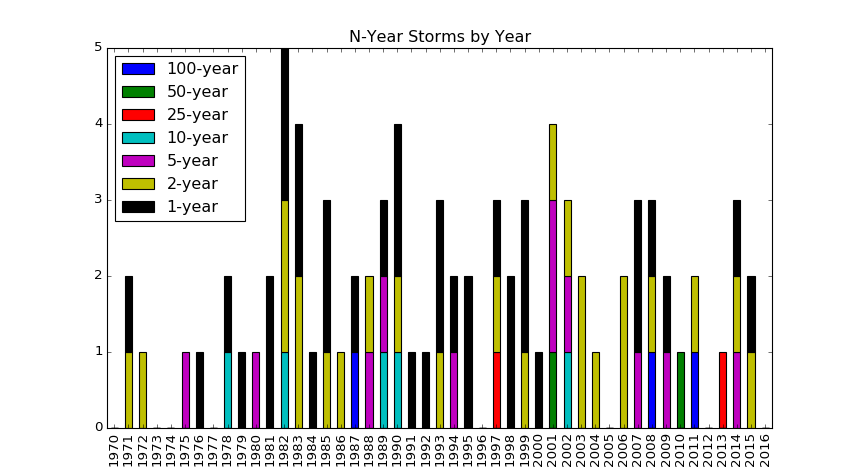

In [64]:
ns_by_year = ns_by_year[ns_by_year.columns[::-1]]  # Reverse column order
ns_by_year.columns = [str(n) + '-year' for n in ns_by_year.columns]
ns_by_year.plot(kind='bar', stacked=True, title="N-Year Storms by Year")

### From the above, it is not so obvious that there are patterns.  Further analysis will be done in other notebooks.  In order to do so, create a CSV of N-Year storms for further analysis

In [65]:
unique_storms.to_csv('data/n_year_storms_ohare_noaa.csv', index=False)